## Importing Libraries

In [240]:
import os, random
import numpy as np
import pandas as pd
from glob import glob
from skimage import io
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data Entries

In [5]:
all_xray_df = pd.read_csv('../nih-chest-xray/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
93404,00023343_000.png,No Finding,0,23343,43,M,PA,2500,2048,0.168,0.168,NaN
15069,00003951_001.png,No Finding,1,3951,74,F,AP,2500,2048,0.168,0.168,NaN
63786,00015734_002.png,No Finding,2,15734,28,F,PA,2048,2500,0.168,0.168,NaN


In [6]:
all_xray_df.shape

(112120, 12)

In [4]:
data_sample = pd.read_csv('./sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
38,00000232_000.png,Fibrosis,0,232,045Y,M,PA,2992,2991,0.143,0.143
4078,00020113_018.png,Atelectasis|Effusion,18,20113,038Y,M,AP,3056,2544,0.139,0.139
1007,00005248_001.png,Infiltration,1,5248,052Y,F,PA,2500,2048,0.171,0.171


In [7]:
data_sample.shape

(5606, 11)

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## Data Preprocessing

In [83]:
# Enumerate Labels
all_labels_raw = [item for sublist in all_xray_df['Finding Labels'].map(lambda x: x.split('|')).to_list() for item in sublist]
all_labels = np.unique(all_labels_raw)
print(f'All Labels ({len(all_labels)}): {all_labels}')

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [24]:
# One-Hot Encoding for All Labels: Sample Data
for label in all_labels:
    data_sample[label] = data_sample['Finding Labels'].map(lambda finding: 1. if label in finding else 0.)

In [26]:
data_sample.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# One-Hot Encoding for All Labels: All Xray Data
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1. if label in finding else 0.)

all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Demography

There are 1431 images with positive pneumonia label.

### Gender

In [121]:
all_gender = all_xray_df['Patient Gender'].value_counts()
all_gender

Patient Gender
M    63340
F    48780
Name: count, dtype: int64

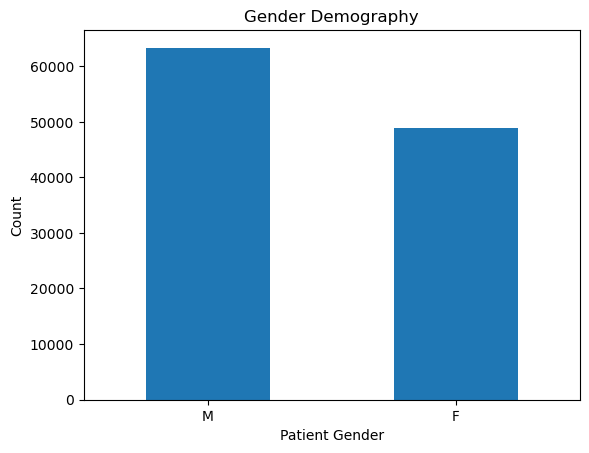

In [123]:
all_gender.plot(kind='bar', title='Gender Demography', ylabel='Count', rot=1);

In [124]:
print(f'All xray data consists of {100*all_gender["M"]/all_gender.sum():.2f}% male and {100*all_gender["F"]/all_gender.sum():.2f}% female.')


All xray data consists of 56.49% male and 43.51% female.


### Age

In [125]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [132]:
all_xray_df[all_xray_df['Patient Age'] > 140]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


There are 16 data containing patient with age above 120. This is most likely an input error, since they are all above 140 years old.

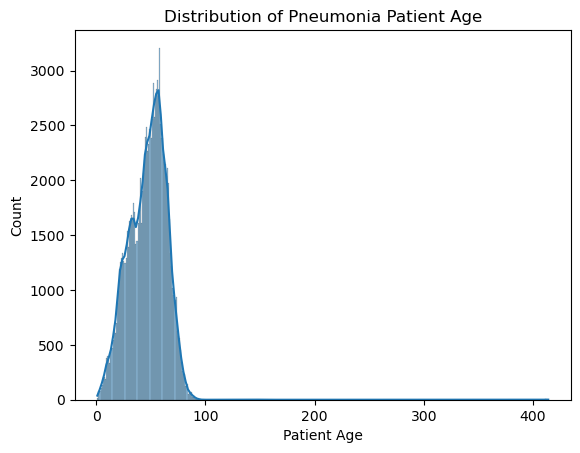

In [133]:
ax = sns.histplot(all_xray_df['Patient Age'], kde=True)
ax.set_title('Distribution of Pneumonia Patient Age');

The histogram is skewed to the right due to the existence of above 400 years old patient data.

## View Position

In [134]:
all_pos = all_xray_df['View Position'].value_counts()
all_pos

View Position
PA    67310
AP    44810
Name: count, dtype: int64

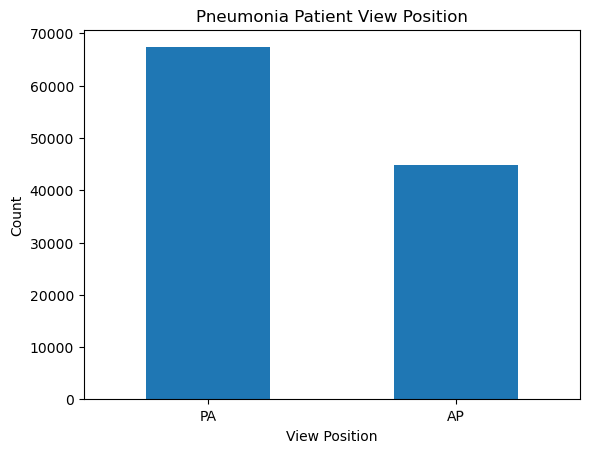

In [135]:
all_pos.plot(kind='bar', title='Pneumonia Patient View Position', ylabel='Count', rot=1);

In [136]:
print(f'All xray data consists of {100*all_pos["AP"]/all_pos.sum():.2f}% AP (Anteroposterior) view and {100*all_pos["PA"]/all_pos.sum():.2f}% PA (Posteroanterior) view.')


All xray data consists of 39.97% AP (Anteroposterior) view and 60.03% PA (Posteroanterior) view.


## Cases Distribution

In [142]:
all_labels_count = pd.Series(all_labels_raw).value_counts()
all_labels_count

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: count, dtype: int64

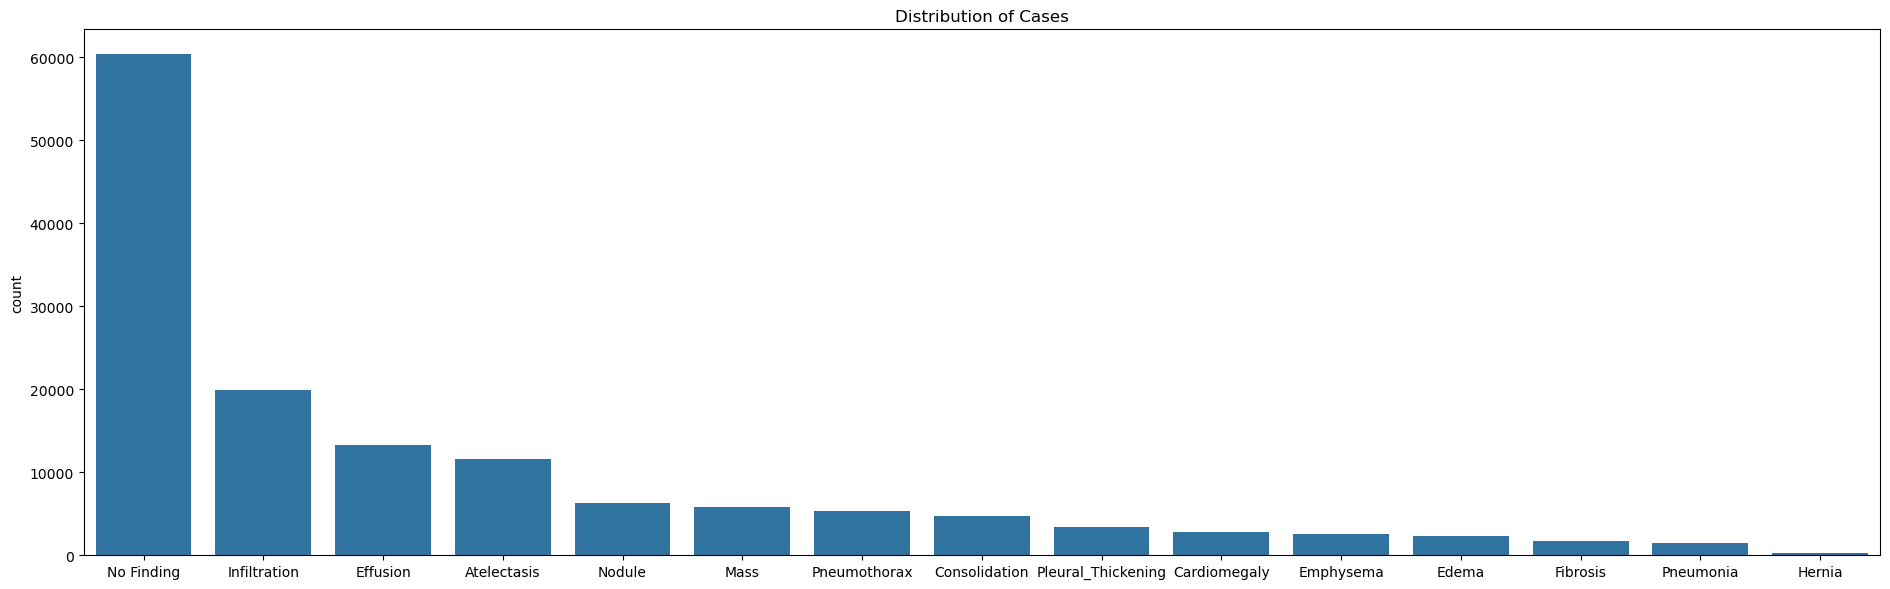

In [140]:
fig, ax = plt.subplots(figsize=(19, 6))
ax.set_title('Distribution of Cases')
sns.barplot(all_labels_count, ax=ax)
plt.tight_layout()

In [148]:
print(f"""
Most of the data are without any case or finding (60,361 cases constituting {100*all_labels_count["No Finding"]/all_labels_count.sum():.2f}%), 
with the top 5 cases including Infiltration, Effusion, Atelatasis, Nodule, and Mass. 
Pneumonia comes second to last with 1,431 cases constituting {100*1431/all_labels_count.sum():.2f}% of the dataset.
Non-pneumonia cases are {all_labels_count.sum() - 1431 - 60361:,}.
""")



Most of the data are without any case or finding (60,361 cases constituting 42.65%), 
with the top 5 cases including Infiltration, Effusion, Atelatasis, Nodule, and Mass. 
Pneumonia comes second to last with 1,431 cases constituting 1.01% of the dataset.
Non-pneumonia cases are 79,745.



## Pneumonia Comorbids

In [28]:
all_pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 1]

In [157]:
comorbid_labels = np.setdiff1d(all_labels, ['No Finding', 'Pneumonia'])

In [166]:
comorbid_sum = all_pneumonia_df[comorbid_labels].sum(axis=0).sort_values(ascending=False)

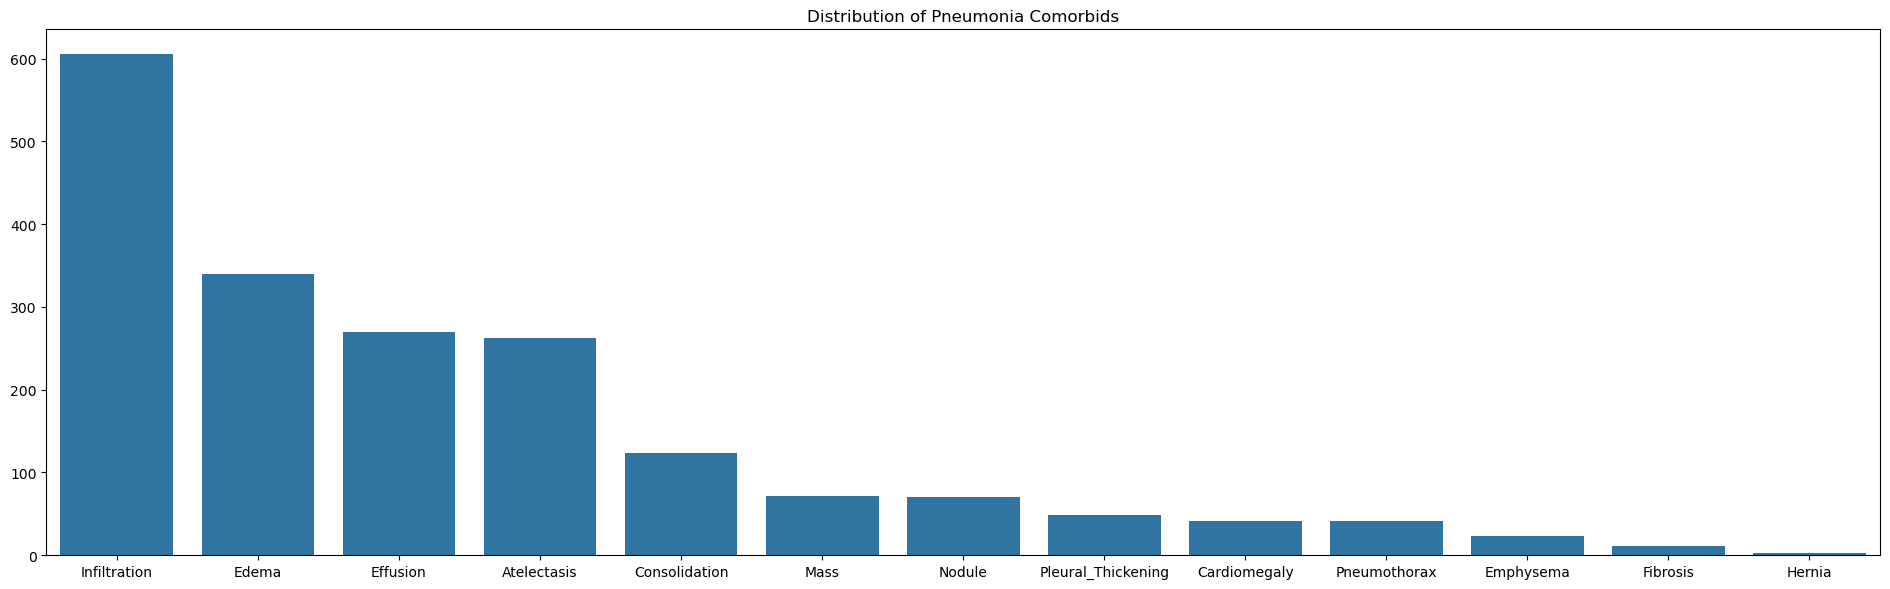

In [167]:
fig, ax = plt.subplots(figsize=(19, 6))
ax.set_title('Distribution of Pneumonia Comorbids')
sns.barplot(comorbid_sum, ax=ax)
plt.tight_layout()

The top 5 comorbid cases found in the dataset are Infiltration, Edema, Effusion, Atelectasis, and Consolidation.

## Number of Diseases per Patient

In [171]:
disease_num = all_xray_df[np.setdiff1d(all_labels, ['No Finding'])].sum(axis=1)

In [186]:
disease_num.value_counts()

0.0    60361
1.0    30963
2.0    14306
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
9.0        2
8.0        1
Name: count, dtype: int64

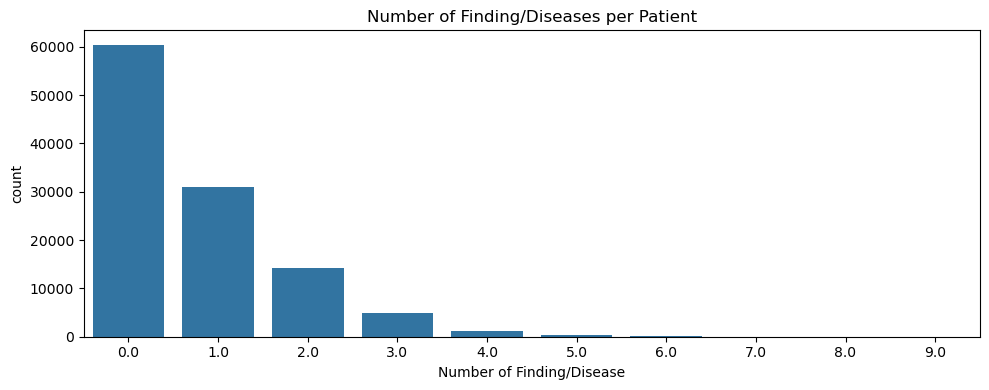

In [184]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Number of Finding/Diseases per Patient')
ax.set_xlabel('Number of Finding/Disease')
sns.barplot(disease_num.value_counts(), ax=ax)
plt.tight_layout()

Most patients have no disease found and the number gets fewer the higher the number of diseases found.

## Pixel Level Assessment of Diseases

In [193]:
image_folders = [folder for folder in os.listdir('../nih-chest-xray/') if 'images' in folder]

In [249]:
# Get the list of all diseases
all_diseases = np.setdiff1d(all_labels, ['No Finding'])

# Randomly gett "No Finding" image object
np.random.seed(42)
no_findings = data_sample[data_sample['No Finding'] == 1]
no_finding = no_findings.sample(1).iloc[0]
no_finding_file = no_finding['Image Index']

for folder in image_folders:
    file_list = os.listdir(f'../nih-chest-xray/{folder}/images/')

    if no_finding_file in file_list:
        no_finding_img = io.imread(f'../nih-chest-xray/{folder}/images/{no_finding_file}')

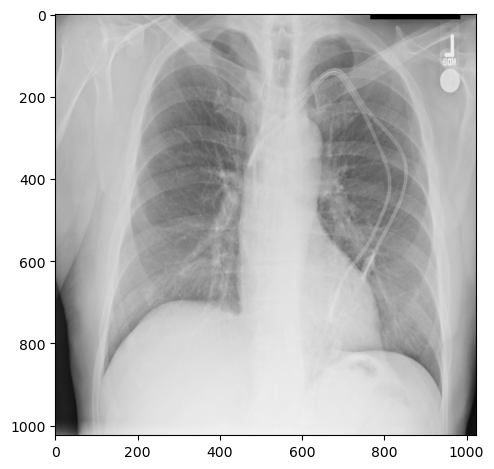

In [251]:
plt.imshow(no_finding_img, cmap='grey')
plt.tight_layout()

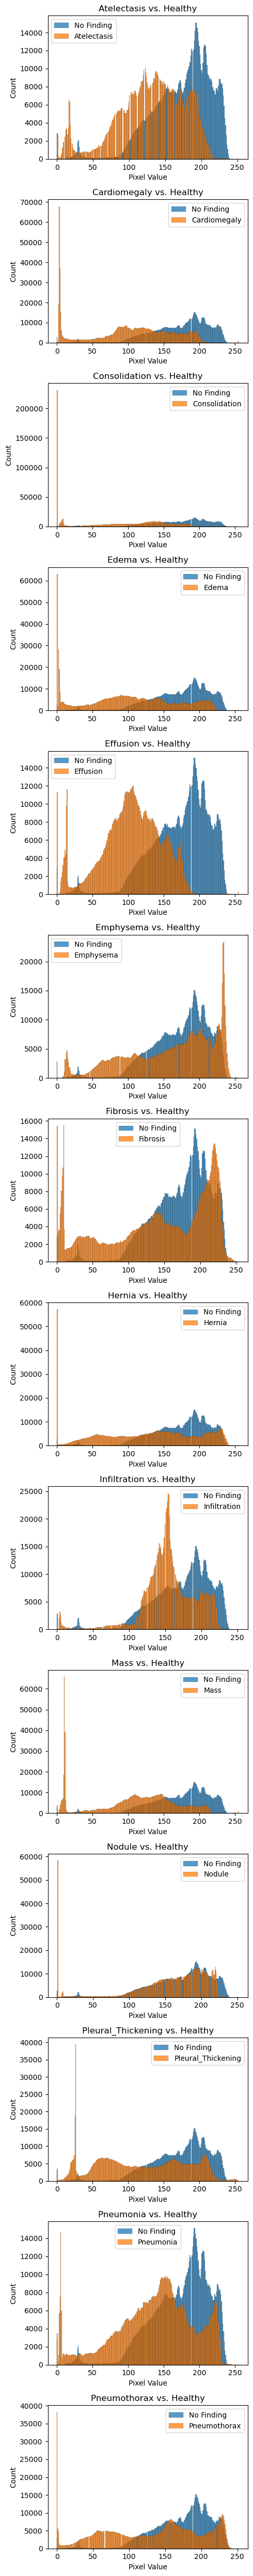

In [262]:
# Plot Comparisons of Each Disease Pixel Intensity with the Picked Healthy Image
fig, axs = plt.subplots(len(all_diseases), 1, figsize=(5, 50))

for idx, disease in enumerate(all_diseases):
    np.random.seed(42)
    disease_df = data_sample[data_sample[disease] == 1]
    disease_sample = disease_df.sample(1).iloc[0]
    img_path = disease_sample['Image Index']

    # Find the image path
    for folder in image_folders:
        file_list = os.listdir(f'../nih-chest-xray/{folder}/images/')
    
        if img_path in file_list:
            img = io.imread(f'../nih-chest-xray/{folder}/images/{img_path}') # load the image

    sns.histplot(no_finding_img.ravel(), bins=256, ax=axs[idx], label='No Finding')
    sns.histplot(img.ravel(), bins=256, ax=axs[idx], label=disease)
    axs[idx].set_title(f'{disease} vs. Healthy')
    axs[idx].set_xlabel('Pixel Value')
    axs[idx].legend()

plt.tight_layout()

## Remarks

Out of 112,120 images in the dataset, only 1,431 found to be labelled with pneumonia. This is 1.01% of the dataset, which cannot be assumed to be the prevalence in the real world. Based on [Ragunath and Oba's book](https://www.ncbi.nlm.nih.gov/books/NBK430749/), the prevalence of pneumonia is 1.5 to 14 cases per 1,000 people worldwide and 24.8 cases per 10,000 people in the US alone.

In building the algorithm, the split of the pneumonia images will be 80% for the training set and 20% for the validation set. In the training set, the composition of pneumonia and healthy chest images will be 50:50, while it will be reflecting the real world (1.4:100) in the validation set.

The training set will also include balance composition of the comorbids, genders, and age groups, while the validation set will reflect the composition of the dataset.